In [ ]:
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py

import torch
from torch import nn

!pip install einops
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision
# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            # nn.Linear(dim, hidden_dim),
            nn.Conv2d(dim, hidden_dim,1),
            nn.GELU(),
            nn.Dropout(dropout),
            # nn.Linear(hidden_dim, dim),
            nn.Conv2d(hidden_dim, dim, 1),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        x = rearrange(x, 'b p c -> c p b')
        x = self.net(x)
        x = rearrange(x, 'c p b -> b p c')
        return x

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        # self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_qkv = nn.Sequential(
            Rearrange('b p dim -> dim b p'),
            nn.Conv2d(dim,inner_dim * 3, 1),
            Rearrange('i_dim b p -> b p i_dim')

        )
        self.to_out = nn.Sequential(
            Rearrange('b p i_dim -> i_dim b p'),
            nn.Conv2d(inner_dim, dim, 1),
            Rearrange('dim b p -> b p dim'),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        ## input x = (b , patch + 1 , dim = 128) -> output qkv = (b, patch + 1 , dim_heads * heads * 3)
        qkv = self.to_qkv(x).chunk(3, dim = -1)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv) ### separating into different heads

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')### combining all the heads
        # print(out.shape)

        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            # input(batch,channel,heightImage, widthImage) -> output(batch, h*w of patch, dim_embedding_of_patch)
            # Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),       ###. h* p1 = height of original img therefor h = height of the patch , output = batch, dim of patches, patch dim(type of embedding for each patch).
            # nn.Linear(patch_dim, dim),
            nn.Conv2d(3, dim , kernel_size = (patch_height, patch_width), stride = (patch_height, patch_width)), # output(b, num of patches , patch_dim_embedding)
            Rearrange('b c h w -> b (h w) c')
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            Rearrange('(b c) dim -> dim b c', c = 1),
            nn.Conv2d(dim, num_classes, 1),
            Rearrange('class b c -> (b c) class')
        )

    def forward(self, img):
        # print(12)
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape
        # print(b,n) ## b = batch number, n = number of patches = 63 in this case.
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        x = self.transformer(x)

        # x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        cls = x[ : , 0] ## extracts the cls token from the x

        cls = self.to_latent(cls)
        cls = self.mlp_head(cls)
        return cls

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model = ViT( image_size = (32,32), patch_size = (4,4), num_classes = 10, dim = 128, depth = 6, heads = 8, mlp_dim = 256 )
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.to(device)
summary(model, input_size=(3, 32, 32))

/usr/local/lib/python3.9/dist-packages/einops/parsing.py:136: RuntimeWarning: It is discouraged to use axes names that are keywords: class
  warnings.warn("It is discouraged to use axes names that are keywords: {}".format(name), RuntimeWarning)


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 128, 8, 8]           6,272
         Rearrange-2              [-1, 64, 128]               0
           Dropout-3              [-1, 65, 128]               0
         LayerNorm-4              [-1, 65, 128]             256
         Rearrange-5                [-1, 2, 65]               0
            Conv2d-6                [-1, 2, 65]         198,144
         Rearrange-7             [-1, 65, 1536]               0
           Softmax-8            [-1, 8, 65, 65]               0
         Rearrange-9                [-1, 2, 65]               0
           Conv2d-10                [-1, 2, 65]          65,664
        Rearrange-11              [-1, 65, 128]               0
          Dropout-12              [-1, 65, 128]               0
        Attention-13              [-1, 65, 128]               0
          PreNorm-14              

In [ ]:
IMAGE_SIZE = 32

NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 128
EPOCHS = 25

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-1

cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.75, 1.0), ratio=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandAugment(num_ops=1, magnitude=8),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
    transforms.RandomErasing(p=0.25)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=4)


Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [ ]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
image_batch, label_batch = next(iter(trainloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 32, 32]), tensor(9))

(-0.5, 31.5, 31.5, -0.5)

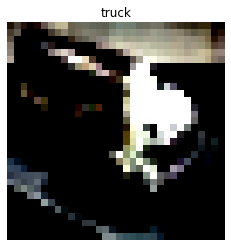

In [ ]:
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(classes[label])
plt.axis(False)

In [ ]:
!git clone https://github.com/shreyash-99/EVA8.git
%cd EVA8/EVA8-all_models-new
from utils import *
from main import *

Cloning into 'EVA8'...
remote: Enumerating objects: 1139, done.
remote: Counting objects: 100% (526/526), done.
remote: Compressing objects: 100% (475/475), done.
remote: Total 1139 (delta 97), reused 471 (delta 48), pack-reused 613
Receiving objects: 100% (1139/1139), 30.63 MiB | 22.69 MiB/s, done.
Resolving deltas: 100% (461/461), done.
/content/EVA8/EVA8-all_models-new


In [ ]:
import shutil

In [ ]:

# %cd ..
# %cd ..
shutil.rmtree('EVA8')

In [ ]:
import time

clip_norm = True
lr_schedule = lambda t: np.interp([t], [0, EPOCHS*2//5, EPOCHS*4//5, EPOCHS], 
                                  [0, 0.01, 0.01/20.0, 0])[0]

model = nn.DataParallel(model, device_ids=[0]).cuda()
opt = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

for epoch in range(EPOCHS):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    for i, (X, y) in enumerate(trainloader):
        model.train()
        X, y = X.cuda(), y.cuda()

        lr = lr_schedule(epoch + (i + 1)/len(trainloader))
        opt.param_groups[0].update(lr=lr)

        opt.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(X)
            loss = criterion(output, y)

        scaler.scale(loss).backward()
        if clip_norm:
            scaler.unscale_(opt)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt)
        scaler.update()
        
        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)
        
    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)

    print(f'Epoch: {epoch} | Train Acc: {train_acc/n:.4f}, Test Acc: {test_acc/m:.4f}, Time: {time.time() - start:.1f}, lr: {lr:.6f}')

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 0 | Train Acc: 0.3131, Test Acc: 0.4442, Time: 85.4, lr: 0.001000
Epoch: 1 | Train Acc: 0.4237, Test Acc: 0.4842, Time: 75.6, lr: 0.002000
Epoch: 2 | Train Acc: 0.4218, Test Acc: 0.4522, Time: 75.2, lr: 0.003000
Epoch: 3 | Train Acc: 0.4224, Test Acc: 0.4794, Time: 74.3, lr: 0.004000
Epoch: 4 | Train Acc: 0.4512, Test Acc: 0.5054, Time: 75.7, lr: 0.005000
Epoch: 5 | Train Acc: 0.4801, Test Acc: 0.4967, Time: 75.7, lr: 0.006000
Epoch: 6 | Train Acc: 0.5001, Test Acc: 0.5551, Time: 74.2, lr: 0.007000
Epoch: 7 | Train Acc: 0.5148, Test Acc: 0.5351, Time: 75.4, lr: 0.008000
Epoch: 8 | Train Acc: 0.5171, Test Acc: 0.5613, Time: 75.3, lr: 0.009000
Epoch: 9 | Train Acc: 0.5247, Test Acc: 0.5550, Time: 74.4, lr: 0.010000
Epoch: 10 | Train Acc: 0.5450, Test Acc: 0.5748, Time: 74.9, lr: 0.009050
Epoch: 11 | Train Acc: 0.5595, Test Acc: 0.6152, Time: 75.2, lr: 0.008100
Epoch: 12 | Train Acc: 0.5733, Test Acc: 0.6108, Time: 76.7, lr: 0.007150
Epoch: 13 | Train Acc: 0.5879, Test Acc: 0.6298,

In [ ]:
plotGradCAM(model, testloader, classes, device)